<a href="https://colab.research.google.com/github/dexter-nguyen/Stock-Price-Prediction/blob/main/stock_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ta yfinance

     |████████████████████████████████| 63 kB 936 kB/s 
     |████████████████████████████████| 6.4 MB 32.3 MB/s 
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28908 sha256=46676ab0293c31e768bdfbf8b649252e68d5ed0ceebd140325d53ae741f263e9
  Stored in directory: /root/.cache/pip/wheels/72/78/64/cc1c01506a1010a9845e9bd7c69333730f7174661228ea4f98
Successfully built ta
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium=

Enter the stock ticker: AAPL
 1. Chart Comparision
 2. Prediction for the next day
 3. Exit
Please enter your selection: 1
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data of  AAPL  from  2018-01-01  to  2021-07-02 

                  High         Low   Adj Close
Date                                          
2018-01-02   43.075001   42.314999   41.135750
2018-01-03   43.637501   42.990002   41.128590
2018-01-04   43.367500   43.020000   41.319630
2018-01-05   43.842499   43.262501   41.790066
2018-01-08   43.902500   43.482498   41.634853
...                ...         ...         ...
2021-06-25  133.889999  132.809998  132.548294
2021-06-28  135.250000  133.350006  134.211258
2021-06-29  136.490005  134.350006  135.754700
2021-06-30  137.410004  135.869995  136.382065
2021-07-01  137.330002  135.759995  136.690735

[881 ro

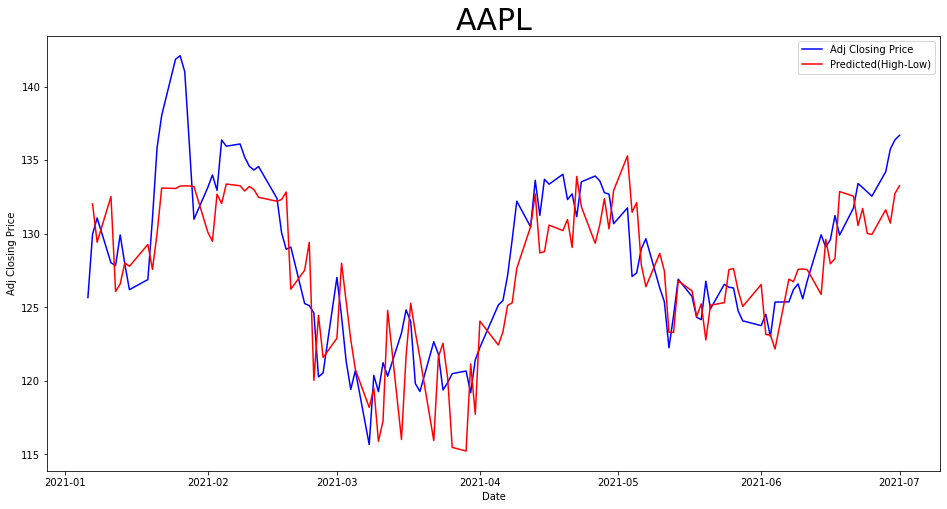

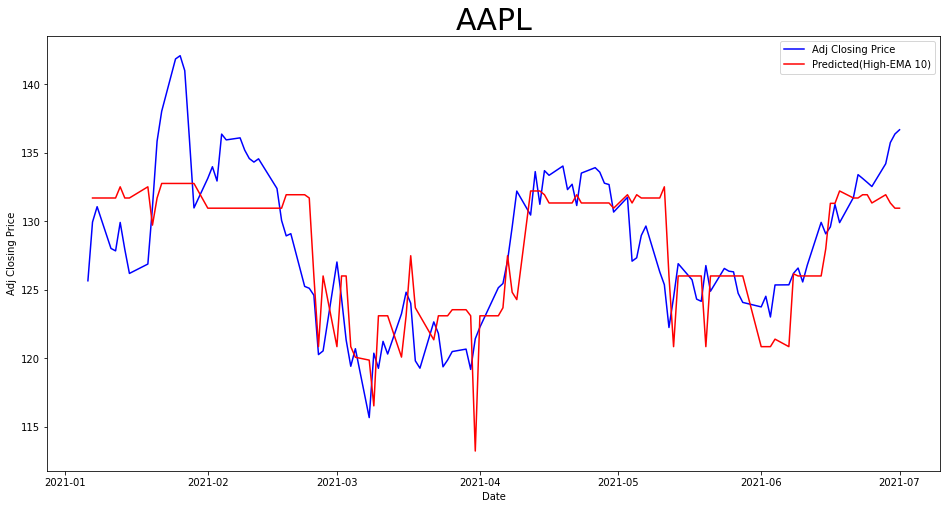

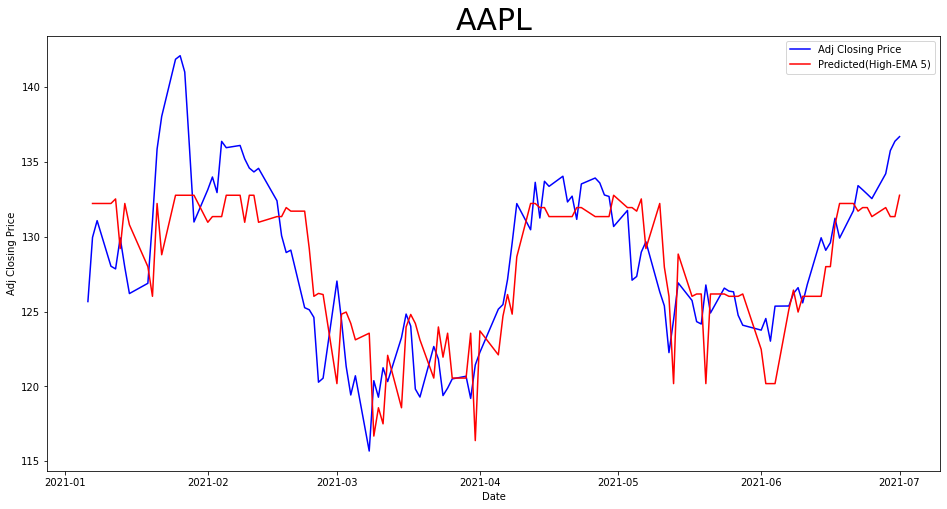



Performance measure for predicted price of AAPL 

High-Low
MAE:   2.6839765278217493
RMSE:  3.222964699482196
R2:    0.6559639171481229

High-EMA(10)
MAE:   2.898526321994801
RMSE:  3.554638748168856
R2:    0.581511201396272

High-EMA(5)
MAE:   2.7777682653541778
RMSE:  3.461108459868094
R2:    0.6032441724595148


In [10]:
# -------------------------------------------------------------------------
# FILENAME: knn_stock.py
# SPECIFICATION: Stock price prediction with KNN regression
# -----------------------------------------------------------*/

from datetime import date
from datetime import timedelta
import ta
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


def chart_comparision(ticker):
    # Date for training and testing, test split ratio
    end_date = date(2021, 7, 2)
    start_date = date(2018, 1, 1)
    train_date = date(2021, 1, 6)
    SPLIT_PERCENT = 0.86    # Split 86:14 for train and test

    # Input the stock ticker

    # Download data with yfinance
    # 1/3/2017 to 1/5/2021
    train_data = yf.download(ticker, start_date, train_date)
    # 1/6/2021 to 7/1/2021
    test_data = yf.download(ticker, train_date, end_date)

    # Print the entire dataset
    df = yf.download(ticker, start_date, end_date)
    print('\nData of ', ticker, ' from ', start_date, ' to ', end_date, '\n')
    print(df.drop(['Open', 'Close', 'Volume'], axis=1))

    # --------------------High and Low-------------------------------------------------
    # Match the (High and Low) of today to the (Adj Close) price of tommorow
    # only keep high and low
    X_train = train_data.drop(['Open', 'Close', 'Volume', 'Adj Close'], axis=1)
    X_train.drop(X_train.tail(1).index, inplace=True)  # delete the last day

    Y_train = train_data['Adj Close']
    Y_train.drop(Y_train.head(1).index, inplace=True)  # delete the first day

    # only keep high and low
    x_test = test_data.drop(['Open', 'Close', 'Volume', 'Adj Close'], axis=1)
    x_test.drop(x_test.tail(1).index, inplace=True)  # Delete the last day

    y_test = test_data['Adj Close']
    y_test.drop(y_test.head(1).index, inplace=True)  # Delete the first day

    # K: from 1 to 25, cv = 5, and Negative MAE scoring
    model = GridSearchCV(neighbors.KNeighborsRegressor(),
                         param_grid={'n_neighbors': np.arange(1, 25, 1), 'weights': [
                             'distance', 'uniform']},
                         cv=5,  refit=True, scoring='neg_mean_absolute_error')
    model.fit(X_train, Y_train)
    preds_hl = model.predict(x_test)
    score_hl = model.score(X_train, Y_train)

    # ------------------High and EMA-10----------------------------------------------------
    # Match the (High and EMA 10) of today to the (Adj Close) price of tommorow
    pd.options.mode.chained_assignment = None
    df_new = yf.download(ticker, start_date - timedelta(days=16), end_date)
    new_data = df_new[['Adj Close', 'High']]  # new_data with only adj close
    new_data['EMA'] = ta.trend.ema_indicator(
        new_data['Adj Close'], window=10)  # EMA with period = 10
    new_data.dropna(how='any', inplace=True)  # drop all rows with NaN

    split = int(SPLIT_PERCENT*len(new_data))

    X_train = new_data[:split].drop(['Adj Close'], axis=1)
    X_train.drop(X_train.tail(1).index, inplace=True)  # delete the last day

    Y_train = new_data[:split]['Adj Close']
    Y_train.drop(Y_train.head(1).index, inplace=True)  # delete the first day

    x_test = new_data[split:].drop(['Adj Close'], axis=1)
    x_test .drop(x_test.tail(1).index, inplace=True)  # delete the last day
    # Adjust the first day to match with previous testing data
    x_test .drop(x_test.head(1).index, inplace=True)

    y_test = new_data[split:]['Adj Close']
    y_test.drop(y_test.head(2).index, inplace=True)  # delete the first day

    model.fit(X_train, Y_train)
    preds_h_ema10 = model.predict(x_test)

    # -----------------High and EMA-8------------------------
    # Match the (High and EMA 8) of today to the (Adj Close) price of tommorow
    df_new = yf.download(ticker, start_date - timedelta(days=12), end_date)
    new_data = df_new[['Adj Close', 'High']]  # new_data with only adj close
    new_data['EMA'] = ta.trend.ema_indicator(
        new_data['Adj Close'], window=5)  # EMA with period = 5
    new_data.dropna(how='any', inplace=True)  # drop all rows with NaN

    split = int(SPLIT_PERCENT*len(new_data))

    X_train = new_data[:split].drop(['Adj Close'], axis=1)
    X_train.drop(X_train.tail(1).index, inplace=True)  # delete the last day

    Y_train = new_data[:split]['Adj Close']
    Y_train.drop(Y_train.head(1).index, inplace=True)  # delete the first day

    x_test = new_data[split:].drop(['Adj Close'], axis=1)
    x_test .drop(x_test.tail(1).index, inplace=True)  # delete the last day
    x_test .drop(x_test.head(1).index, inplace=True)

    y_test = new_data[split:]['Adj Close']
    y_test.drop(y_test.head(2).index, inplace=True)  # delete the first day

    model.fit(X_train, Y_train)
    preds_h_ema5 = model.predict(x_test)

    # Put all predicted of different feature combinations to one dataframe
    result = pd.DataFrame({'High-Low': preds_hl, 'Open-EMA10': preds_h_ema10,
                          'Open-EMA5': preds_h_ema5, 'Adj Close': y_test})
    print('\nPredicted ', ticker,
          ' stock price from different feature combinations\n')
    print(result)

    # Plot the result
    plt.figure(figsize=(16, 8))
    plt.xlabel('Date')
    plt.ylabel('Adj Closing Price')
    plt.title(label=ticker, fontsize=30)
    plt.plot(test_data['Adj Close'], 'b-', label='Adj Closing Price')
    plt.plot(result['High-Low'], 'r-', label='Predicted(High-Low)')
    plt.legend()
    plt.show()
    print()

    plt.figure(figsize=(16, 8))
    plt.xlabel('Date')
    plt.ylabel('Adj Closing Price')
    plt.title(label=ticker, fontsize=30)
    plt.plot(test_data['Adj Close'], 'b-', label='Adj Closing Price')
    plt.plot(result['Open-EMA10'], 'r-', label='Predicted(High-EMA 10)')
    plt.legend()
    plt.show()
    print()

    plt.figure(figsize=(16, 8))
    plt.xlabel('Date')
    plt.ylabel('Adj Closing Price')
    plt.title(label=ticker, fontsize=30)
    plt.plot(test_data['Adj Close'], 'b-', label='Adj Closing Price')
    plt.plot(result['Open-EMA5'], 'r-', label='Predicted(High-EMA 5)')
    plt.legend()
    plt.show()
    print()

    # Printing performance measures
    # y_test the same for all feature combinations

    print("\nPerformance measure for predicted price of", ticker, '\n')
    print("High-Low")
    print("MAE:  ", mean_absolute_error(y_test.values, preds_hl))
    print("RMSE: ", math.sqrt(mean_squared_error(y_test.values, preds_hl)))
    print("R2:   ", r2_score(y_test.values, preds_hl))

    print("\nHigh-EMA(10)")
    print("MAE:  ", mean_absolute_error(y_test.values, preds_h_ema10))
    print("RMSE: ", math.sqrt(mean_squared_error(y_test.values, preds_h_ema10)))
    print("R2:   ", r2_score(y_test.values, preds_h_ema10))

    print("\nHigh-EMA(5)")
    print("MAE:  ", mean_absolute_error(y_test.values, preds_h_ema5))
    print("RMSE: ", math.sqrt(mean_squared_error(y_test.values, preds_h_ema5)))
    print("R2:   ", r2_score(y_test.values, preds_h_ema5))


def predict_next_day(ticker):
    # Date for training and testing, test split ratio
    end_date = date.today() - timedelta(90)
    start_date = date(2018, 1, 1)

    # Download data with yfinance
    train_data = yf.download(ticker, start_date, end_date)
    test_data = yf.download(ticker, end_date, date.today() - timedelta(1))

    print("------------------TRAIN DATA---------------------")
    print(train_data)
    print("------------------TEST DATA----------------------")
    print(test_data)
    # K: from 1 to 25, cv = 5, and Negative MAE scoring
    model = GridSearchCV(neighbors.KNeighborsRegressor(),
                         param_grid={'n_neighbors': np.arange(1, 25, 1), 'weights': [
                             'distance', 'uniform']},
                         cv=5,  refit=True, scoring='neg_mean_absolute_error')
    previous_day = test_data.iloc[-1:]
    print(previous_day, "\n")

    high_low(train_data, test_data, model)
    high_ema(train_data, test_data, model, 5)
    high_ema(train_data, test_data, model, 10)
    high_ema(train_data, test_data, model, 50)


def high_low(train_data, test_data, model):
    # only keep high and low
    X_train = train_data.drop(['Open', 'Close', 'Volume', 'Adj Close'], axis=1)
    shift_day(X_train, 2)

    Y_train = train_data['Adj Close']
    shift_day(Y_train, 1)

    # only keep high and low
    x_test = test_data.drop(['Open', 'Close', 'Volume', 'Adj Close'], axis=1)
    x_previous_date = pd.concat([x_test.tail(1)])

    model.fit(X_train, Y_train)

    preds_hl = model.predict(x_previous_date)
    print("Predicted price of", ticker, "for", date.today(),
          "(high-low): ", round(float(preds_hl), 2))


def high_ema(train_data, test_data, model, ema):
   # -----------------High and EMA------------------------
    # Match the (High) and (EMA) of today to the (Adj Close) price of tommorow
    pd.options.mode.chained_assignment = None
    # new_data with only adj close
    new_data = train_data[['High', 'Adj Close']]

    new_data['EMA'] = ta.trend.ema_indicator(
        new_data['Adj Close'], window=ema)  # Add EMA
    new_data.dropna(how='any', inplace=True)  # drop all rows with NaN

    X_train = new_data[['High', 'EMA']]
    Y_train = new_data['Adj Close']

    shift_day(X_train, 2)  # Delete the first day
    shift_day(Y_train, 1)  # Delete the last

    model.fit(X_train, Y_train)

    x_previous_date = test_data[['High']]
    x_previous_date['EMA'] = ta.trend.ema_indicator(
        test_data['Adj Close'], window=ema)  # Add EMA
    x_previous_date.dropna(how='any', inplace=True)
    x_previous_date = x_previous_date.iloc[-1:]

    preds_hl = model.predict(x_previous_date)
    # print(x_previous_date)
    print("Predicted price of", ticker, "for", date.today(),
          "(high-EMA", ema, "):", round(float(preds_hl), 2))


def shift_day(frame, num):
    # 1 = head, 2 = tail
    if num == 1:
        frame.drop(frame.head(1).index, inplace=True)
    else:
        frame.drop(frame.tail(1).index, inplace=True)


# --------------------------------------------------------------------------------------
cond = True
ticker = input("Enter the stock ticker: ")
choice = input(
    " 1. Chart Comparision\n 2. Prediction for the next day\n 3. Exit\nPlease enter your selection: ")
choice = int(choice)
if choice == 1:
    chart_comparision(ticker)
elif choice == 2:
    predict_next_day(ticker)
else:
    print('Bye')
